In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10.0, 6.0)

In [3]:
import scipy.stats

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D

In [5]:
import sklearn.preprocessing
import sklearn.model_selection

In [6]:
import uproot
uproot.default_library = "np"

In [7]:
import os.path

In [8]:
import logging
logging.basicConfig(level=logging.INFO)

In [9]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

### Data

In [10]:
raw_names = [
    "data/sim09g_KJpsi_2017MD_folded.root:DecayTree;1",
    "data/sim09g_KJpsi_mumu2017MD.root:B2XMuMu_Line_Tuple/DecayTree;266",
    "data/sim09g_Kee_2017MD_folded.root:DecayTree;1",
    "data/sim09g_Kmumu_2017MD.root:B2XMuMu_Line_Tuple/DecayTree;2",
    
    "DLA/KPsi2See_2018_MD_folded.root:DecayTree;1",
    "DLA/KPsi2S_mumu_2018MD_folded.root:DecayTree;1",
#    "DLA/sim09h_Dplus_PhiPi_2018_MD_folded.root:DecayTree;1",
#    "DLA/sim09h_Dplus_PhiPi_mumu_2018_MD_folded.root:DecayTree;1",
]

In [11]:
raw_files = [uproot.open(os.path.join(os.path.expanduser("~/2021/"), name)) for name in raw_names]

### Truthing

In [12]:
def join_and(*conditions):
    return "&".join(["(%s)"%condition for condition in conditions])
def q2_range(v1, v2):
    return join_and("q2_GeV > %g" % v1, "q2_GeV < %g" % v2)

In [13]:
aliases = {
    "q":      "J_psi_1S_M",
    "q2":     "q**2",
    "q2_GeV": "q2*1e-6",
    "ep_p2":  "e_plus_TRUEPT**2+e_plus_TRUEP_Z**2",
    "em_p2":  "e_minus_TRUEPT**2+e_minus_TRUEP_Z**2",
    "ep_p":   "sqrt(ep_p2)",
    "em_p":   "sqrt(em_p2)",
    "min_pl": "fmin(ep_p, em_p)",
    "max_pl": "fmax(ep_p, em_p)",
    "ppcos_ll":  "e_plus_TRUEP_X*e_minus_TRUEP_X + e_plus_TRUEP_Y*e_minus_TRUEP_Y + e_plus_TRUEP_Z*e_minus_TRUEP_Z",
    "cos_ll":    "ppcos_ll/(ep_p*em_p)",
    "alpha":  "acos(cos_ll)",
}

In [14]:
features = [
    "B_plus_TRUEPT",
    "min_pl",
    "max_pl",
    "q2",
    "ppcos_ll",
    "alpha",
]

In [15]:
raw_all = [f.arrays(features, aliases=aliases, library="np") for f in raw_files]

<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in arccos
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in arccos
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide


In [16]:
# https://arxiv.org/abs/2103.11769
#
q_Kll_selector = q2_range(1.1, 6.0)
#
q_Jpsi_e_selector = q2_range(6.0, 12.96)
q_Jpsi_mu_selector = q2_range(8.68, 10.09)
#
q_psi2S_e_selector = q2_range(9.82, 16.40)
q_psi2S_mu_selector = q2_range(12.5, 14.2)
#
Jpsi_selector = "abs(J_psi_1S_TRUEID)==443"
psi2S_selector = "abs(J_psi_1S_TRUEID)==100443"
B_selector = "abs(B_plus_TRUEID)==521"
B_bg_selector = "B_plus_BKGCAT < 60"
Kp_selector = "abs(K_Kst_TRUEID)==321"
e_selector = join_and("abs(e_minus_TRUEID)==11", "abs(e_plus_TRUEID)==11")
mu_selector = join_and("abs(e_minus_TRUEID)==13", "abs(e_plus_TRUEID)==13")
#
Jll_selector = join_and(B_selector, Kp_selector, Jpsi_selector)
psi2Sll_selector = join_and(B_selector, Kp_selector, psi2S_selector)
Kll_selector = join_and(B_selector, Kp_selector, q_Kll_selector)
#
Je_selector =  join_and(e_selector, Jll_selector, q_Jpsi_e_selector)
Jmu_selector = join_and(mu_selector, Jll_selector, q_Jpsi_mu_selector)
Kee_selector =  join_and(e_selector, Kll_selector)
Kmumu_selector = join_and(mu_selector, Kll_selector)
psi2Se_selector =  join_and(e_selector, psi2Sll_selector, q_psi2S_e_selector)
psi2Smu_selector = join_and(mu_selector, psi2Sll_selector, q_psi2S_mu_selector)

In [17]:
selectors = [Je_selector, Jmu_selector, Kee_selector, Kmumu_selector, psi2Se_selector, psi2Smu_selector]
selectors

['((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==443))&((q2_GeV > 6)&(q2_GeV < 12.96))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==443))&((q2_GeV > 8.68)&(q2_GeV < 10.09))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&((q2_GeV > 1.1)&(q2_GeV < 6)))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&((q2_GeV > 1.1)&(q2_GeV < 6)))',
 '((abs(e_minus_TRUEID)==11)&(abs(e_plus_TRUEID)==11))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==100443))&((q2_GeV > 9.82)&(q2_GeV < 16.4))',
 '((abs(e_minus_TRUEID)==13)&(abs(e_plus_TRUEID)==13))&((abs(B_plus_TRUEID)==521)&(abs(K_Kst_TRUEID)==321)&(abs(J_psi_1S_TRUEID)==100443))&((q2_GeV > 12.5)&(q2_GeV < 14.2))']

In [18]:
truthed = [f.arrays(features, sel, aliases=aliases, library="np") for f, sel in zip(raw_files, selectors)]

<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in arccos
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in arccos
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide
<dynamic>:1: RuntimeWarning: invalid value encountered in true_divide


In [19]:
all_data = [("Total", raw_all), ("Truth", truthed)]

In [20]:
df_index = [
    r"$B \to KJ/\psi(\to ee)$",
    r"$B \to KJ/\psi(\to\mu\mu)$",
    r"$B \to Kee$",
    r"$B \to K\mu\mu$",
    r"$B \to K\psi(2S)(\to ee)$",
    r"$B \to K\psi(2S)(\to\mu\mu)$",
]
df = pd.DataFrame(index=df_index)

In [21]:
for name, data in all_data:
    df[name] = [b[features[0]].shape[0] for b in data]
df

Total    Truth
$B \to KJ/\psi(\to ee)$       2084124   696573
$B \to KJ/\psi(\to\mu\mu)$    3206889  1459292
$B \to Kee$                    413741    40094
$B \to K\mu\mu$                665455    72469
$B \to K\psi(2S)(\to ee)$      869415   225328
$B \to K\psi(2S)(\to\mu\mu)$  2313029  1037738

$$\begin{aligned}
R_K&=\frac{\mathcal{B}(B\to K\mu\mu)}{\mathcal{B}(B \to Kee)}\cdot\frac{\mathcal{B}(B\to KJ/\psi(\to ee))}{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}
, \\
R_{\psi(2S)}&=\frac{\mathcal{B}(B\to K\psi(2S)(\to\mu\mu))}{\mathcal{B}(B \to K\psi(2S)(\to ee))}\cdot\frac{\mathcal{B}(B\to KJ/\psi(\to ee))}{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}
, \\
r_{J/\psi}&=\frac{\mathcal{B}(B\to KJ/\psi(\to\mu\mu))}{\mathcal{B}(B\to KJ/\psi(\to ee))}
.
\end{aligned}$$

In [22]:
def double_ratio(a):
    return (a[3]/a[2])/(a[1]/a[0])

In [23]:
def double_ratio_psi2S(a):
    return (a[5]/a[4])/(a[1]/a[0])

In [24]:
double_ratio(df["Truth"]), double_ratio(df["Total"])

(0.8627745334620901, 1.045273065293817)

In [25]:
double_ratio_psi2S(df["Truth"]), double_ratio_psi2S(df["Total"])

(2.1983507867256966, 1.7289943571631468)

### Feature tests

$$\begin{aligned}
\textrm{KS}(F,G)
&= \sup_x \left\vert F(x) - G(x)\right\vert
.
\end{aligned}$$

In [26]:
df_test = pd.DataFrame(index=features, columns=[[],[]])

In [27]:
for name, arr in all_data:
    func = lambda f, ix, iy, fn: f(arr[ix][fn], arr[iy][fn]) if fn in arr[ix] and fn in arr[iy] else None
    ks = lambda a1, a2: scipy.stats.kstest(a1,a2).statistic
    df_test[name, 'e'] = [func(ks, 2, 0, feature) for feature in df_test.index]
    df_test[name, r'$\mu$'] = [func(ks, 3, 1, feature) for feature in df_test.index]

In [28]:
df_test.style.applymap(lambda x: "background-color: yellow" if x > 0.05 else None)

### Graphs

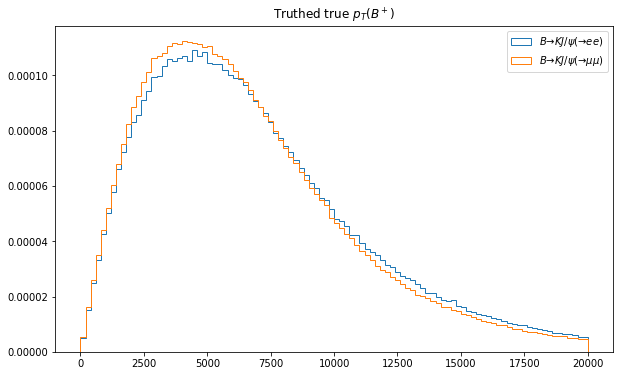

In [29]:
for idx in [0, 1]:
    plt.hist(truthed[idx]['B_plus_TRUEPT'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(0, 20000, 101), histtype='step')
plt.title(r'Truthed true $p_T(B^+)$')
plt.legend()
plt.show()

$$\begin{aligned}
q^2 &= 2p_{\ell^+}p_{\ell^-}(1-\cos\alpha_{\ell\ell})
.
\end{aligned}$$

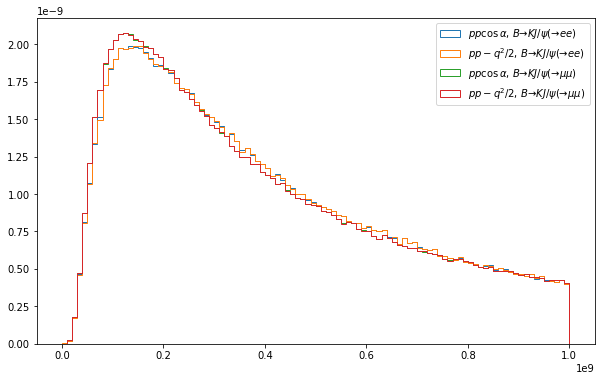

In [30]:
for idx in [0, 1]:
    ti = truthed[idx]
    ppcos = ti['ppcos_ll']
    q2 = ti['q2']
    pp = ti['max_pl']*ti['min_pl']
    plt.hist(ppcos, label=r"$pp\cos\alpha$, %s"%df_index[idx],
             density=True, bins=np.linspace(0,1e9,101), histtype='step')
    plt.hist(pp-q2/2, label=r"$pp-q^2/2$, %s"%df_index[idx],
             density=True, bins=np.linspace(0,1e9,101), histtype='step')
plt.legend()
plt.show()

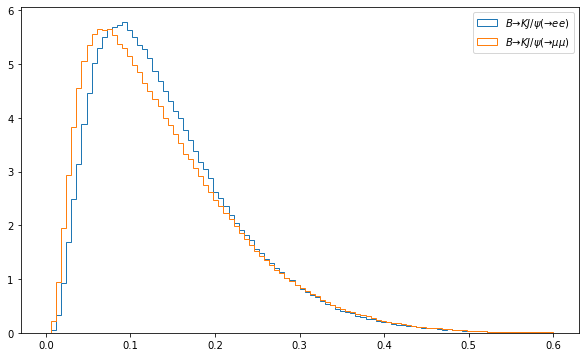

In [31]:
for idx in [0, 1]:
    plt.hist(truthed[idx]['alpha'], label="%s"%df_index[idx],
             density=True, bins=np.linspace(0, 0.6, 101), histtype='step')
plt.legend()
plt.show()

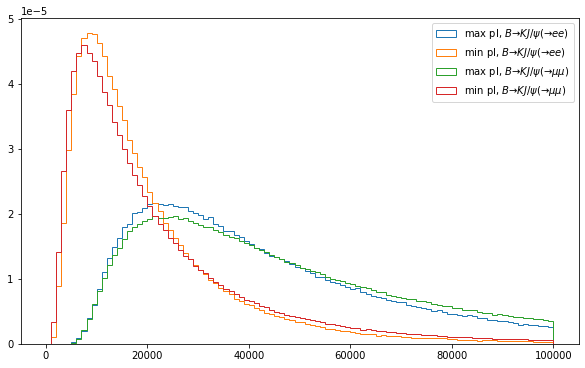

In [32]:
for idx in [0, 1]:
    ti = truthed[idx]
    max_pl = ti['max_pl']
    min_pl = ti['min_pl']
    plt.hist(max_pl, label=r"max pl, %s"%df_index[idx],
             density=True, bins=np.linspace(0,100000,101), histtype='step')
    plt.hist(min_pl, label=r"min pl, %s"%df_index[idx],
             density=True, bins=np.linspace(0,100000,101), histtype='step')
plt.legend()
plt.show()

### Preprocessing

In [33]:
def make_dataset(fnames, idx):
    x = list()
    y = list()
    for i, ix in enumerate(idx):
        x_ = np.hstack([truthed[ix][fn].reshape(-1, 1) for fn in fnames])
        y_ = np.repeat(i, x_.shape[0])
        x.append(x_)
        y.append(y_)
    X = np.vstack(x)
    Y = np.hstack(y)
    return X, Y

In [34]:
X, Y = make_dataset(['B_plus_TRUEPT'], [0, 1])
X.shape, Y.shape

((2155865, 1), (2155865,))

In [35]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, shuffle=True, stratify=Y, test_size=0.1)

In [36]:
y_train.mean(), y_test.mean()

(0.6768937234767389, 0.6768961022696174)

In [37]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(x_train)

StandardScaler()

In [38]:
dataset = torch.utils.data.TensorDataset(
    torch.as_tensor(scaler.transform(x_train), dtype=torch.float, device=device),
    torch.as_tensor(y_train, dtype=torch.long, device=device)
)
loader = torch.utils.data.DataLoader(dataset, batch_size=10000)

In [39]:
counts = np.asarray([np.sum(y_train==label) for label in [0, 1]])
counts

array([ 626916, 1313362])

In [40]:
weights = y_train.shape[0]/counts/2
weights

array([1.54747845, 0.73866839])

### NN

In [41]:
def model():
    return nn.Sequential(
        nn.Linear(1, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 20), nn.Softplus(),
        nn.Linear(20, 1),
    )

In [42]:
def train(model, loader, epochs=20, pos_weight=1):
    model.train()
    opt = torch.optim.Adam(params=model.parameters())
    pw = torch.as_tensor(pos_weight)
    for epoch in range(epochs):
        for batch in loader:
            x, y = batch
            pred = model(x)[:,0]
            loss = F.binary_cross_entropy_with_logits(
                input=pred,
                target=y.float(),
                pos_weight=pw,
            )
            opt.zero_grad()
            loss.backward()
            opt.step()
        logging.info("Epoch %d, %f", epoch, loss)
    model.eval()

In [43]:
m = model().to(device)

In [44]:
train(m, loader, epochs=50, pos_weight=weights[1]/weights[0])

INFO:root:Epoch 0, 0.446866
INFO:root:Epoch 1, 0.446790
INFO:root:Epoch 2, 0.446733
INFO:root:Epoch 3, 0.446686
INFO:root:Epoch 4, 0.446643
INFO:root:Epoch 5, 0.446601
INFO:root:Epoch 6, 0.446561
INFO:root:Epoch 7, 0.446523
INFO:root:Epoch 8, 0.446486
INFO:root:Epoch 9, 0.446450
INFO:root:Epoch 10, 0.446415
INFO:root:Epoch 11, 0.446381
INFO:root:Epoch 12, 0.446348
INFO:root:Epoch 13, 0.446319
INFO:root:Epoch 14, 0.446293
INFO:root:Epoch 15, 0.446270
INFO:root:Epoch 16, 0.446251
INFO:root:Epoch 17, 0.446235
INFO:root:Epoch 18, 0.446222
INFO:root:Epoch 19, 0.446211
INFO:root:Epoch 20, 0.446203
INFO:root:Epoch 21, 0.446197
INFO:root:Epoch 22, 0.446192
INFO:root:Epoch 23, 0.446188
INFO:root:Epoch 24, 0.446186
INFO:root:Epoch 25, 0.446184
INFO:root:Epoch 26, 0.446183
INFO:root:Epoch 27, 0.446182
INFO:root:Epoch 28, 0.446181
INFO:root:Epoch 29, 0.446181
INFO:root:Epoch 30, 0.446181
INFO:root:Epoch 31, 0.446181
INFO:root:Epoch 32, 0.446182
INFO:root:Epoch 33, 0.446182
INFO:root:Epoch 34, 0.44

In [45]:
def to_numpy(t):
    return t.detach().cpu().numpy()
def from_numpy(t):
    return torch.as_tensor(t, dtype=torch.float, device=device)
def as_numpy(f):
    return lambda x: to_numpy(f(from_numpy(x)))

In [46]:
x = np.linspace(0, 20000, 1001).reshape(-1,1)
y = as_numpy(lambda x: torch.exp(m(x)))(scaler.transform(x))

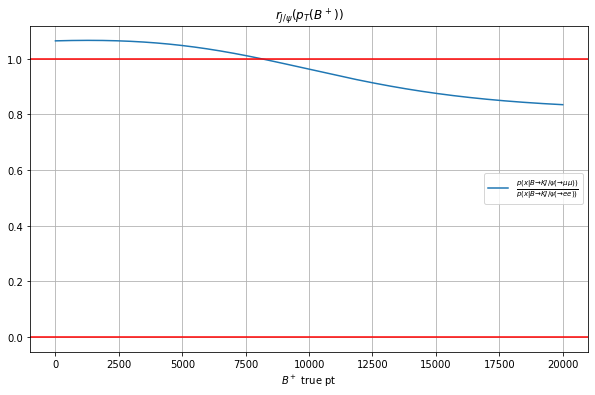

In [47]:
plt.plot(x, y, label=r'$\frac{p(x|B\to KJ/\psi(\to\mu\mu))}{p(x|B\to KJ/\psi(\to ee))}$')
plt.axhline(1.0, color="r")
plt.axhline(0.0, color="r")
plt.grid()
plt.legend()
plt.xlabel(r'$B^+$ true pt')
plt.title(r'$r_{J/\psi}(p_T(B^+))$')
plt.show()

### Reweighting

In [48]:
def weighting_fn(arr):
    arr_ = scaler.transform(np.asarray(arr))
    pred = to_numpy(m(from_numpy(arr_))[:, 0])
    return np.exp(-pred)

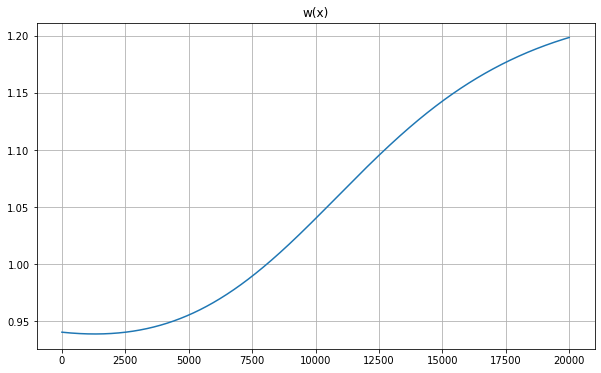

In [49]:
plt.plot(x, weighting_fn(x))
plt.grid()
plt.title("w(x)")
plt.show()

In [50]:
ax = [make_dataset(['B_plus_TRUEPT'],[ix])[0] for ix in range(6)]
wx = [weighting_fn(a) for a in ax]

In [51]:
df["w"] = [1, wx[1].mean(), 1, wx[3].mean(), 1, wx[5].mean()]
df["wTruth"] = df["w"]*df["Truth"]
df

Total    Truth         w        wTruth
$B \to KJ/\psi(\to ee)$       2084124   696573  1.000000  6.965730e+05
$B \to KJ/\psi(\to\mu\mu)$    3206889  1459292  0.994687  1.451539e+06
$B \to Kee$                    413741    40094  1.000000  4.009400e+04
$B \to K\mu\mu$                665455    72469  0.995363  7.213294e+04
$B \to K\psi(2S)(\to ee)$      869415   225328  1.000000  2.253280e+05
$B \to K\psi(2S)(\to\mu\mu)$  2313029  1037738  0.994334  1.031858e+06

In [52]:
double_ratio(df["w"]), double_ratio_psi2S(df["w"])

(1.0006791673650193, 0.9996448363355859)

In [53]:
double_ratio(df["Truth"]), double_ratio(df["wTruth"])

(0.8627745334620901, 0.8633605017685873)

In [54]:
double_ratio_psi2S(df["Truth"]), double_ratio_psi2S(df["wTruth"])

(2.1983507867256966, 2.1975700124046154)

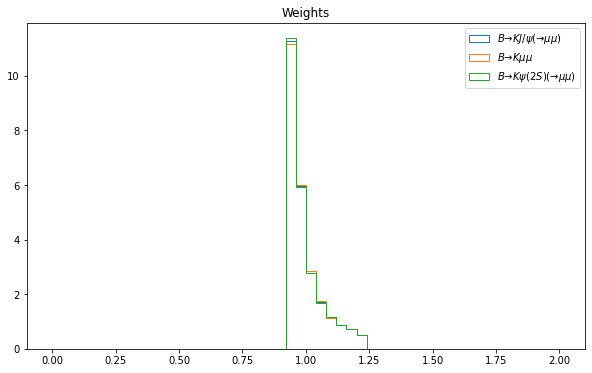

In [55]:
for ix in [1,3,5]:
    plt.hist(wx[ix], label=df_index[ix], density=True, bins=np.linspace(0, 2, 51), histtype='step', cumulative=False)
plt.title('Weights')
plt.legend()
plt.show()

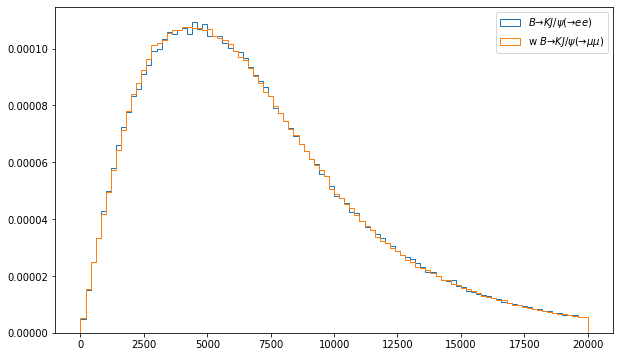

In [56]:
plt.hist(ax[0], label=df_index[0], density=True, bins=np.linspace(0, 20000, 101), histtype='step')
plt.hist(ax[1], weights=wx[1], label="w %s"%df_index[1], density=True, bins=np.linspace(0, 20000, 101), histtype='step')
plt.legend()
plt.show()

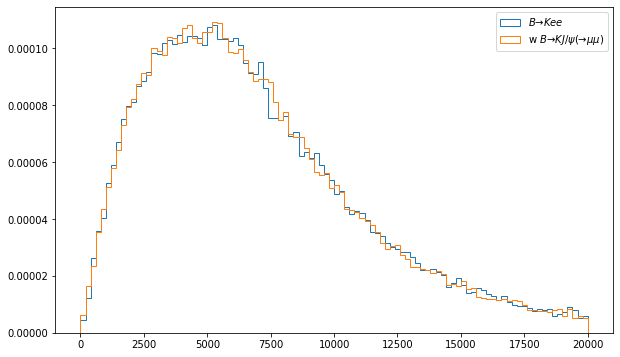

In [57]:
plt.hist(ax[2], label=df_index[2], density=True, bins=np.linspace(0, 20000, 101), histtype='step')
plt.hist(ax[3], weights=wx[3], label="w %s"%df_index[1], density=True, bins=np.linspace(0, 20000, 101), histtype='step')
plt.legend()
plt.show()

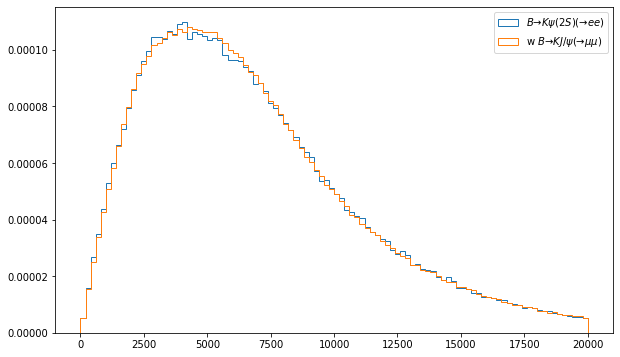

In [58]:
plt.hist(ax[4], label=df_index[4], density=True, bins=np.linspace(0, 20000, 101), histtype='step')
plt.hist(ax[5], weights=wx[5], label="w %s"%df_index[1], density=True, bins=np.linspace(0, 20000, 101), histtype='step')
plt.legend()
plt.show()